# Multi-Resolution Dynamic Mode Decomposition (mrDMD)

Importazione delle librerie necessarie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

Selezione del dataset da utilizzare.

In [2]:
## Parametri per dataset real_eig_timeseries.mat e complex_eig_timeseries.mat
#x = np.linspace(-10, 10, 10)
#t = np.linspace(0, 20, 1600) 

## Parametri per dataset XU_DMDc.mat
#x = np.linspace(0, 40, 40)
#t = np.linspace(0, 7160, 7160) 

## Scelta del dataset, se a valori complessi o reali
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('XU_DMDc.mat')

## Trasformo il formato .mat in un Numpy Array
## Cambiare l'argomento di D_mat['xt'] in D_mat['X'] se si usa il dataset XU_DMDc.mat
#D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
#U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]
#D = np.array(D_mat_list)
#U = np.array(U_mat_list)

## extract input-output matrices
#X = D[:,:-1]
#Y = D[:,1:]
#U = U[:,:]


In [3]:
# define time and space domains
x = np.linspace(-10, 10, 80)
t = np.linspace(0, 20, 1600)
Xm,Tm = np.meshgrid(x, t)

# create data
D = exp(-power(Xm/2, 2)) * exp(0.8j * Tm)
D += sin(0.9 * Xm) * exp(1j * Tm)
D += cos(1.1 * Xm) * exp(2j * Tm)
D += 0.6 * sin(1.2 * Xm) * exp(3j * Tm)
D += 0.6 * cos(1.3 * Xm) * exp(4j * Tm)
D += 0.2 * sin(2.0 * Xm) * exp(6j * Tm)
D += 0.2 * cos(2.1 * Xm) * exp(8j * Tm)
D += 0.1 * sin(5.7 * Xm) * exp(10j * Tm)
D += 0.1 * cos(5.9 * Xm) * exp(12j * Tm)
D += 0.1 * np.random.randn(*Xm.shape)
D += 0.03 * np.random.randn(*Xm.shape)
D += 5 * exp(-power((Xm+5)/5, 2)) * exp(-power((Tm-5)/5, 2))
D[:800,40:] += 2
D[200:600,50:70] -= 3
D[800:,:40] -= 2
D[1000:1400,10:30] += 3
D[1000:1080,50:70] += 2
D[1160:1240,50:70] += 2
D[1320:1400,50:70] += 2
D = D.T

# extract input-output matrices
X = D[:,:-1]
Y = D[:,1:]

Creazione della funzione per plottare i dati.

In [4]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Delayed State')
    plt.ylabel('Time (minute)')
    plt.show()

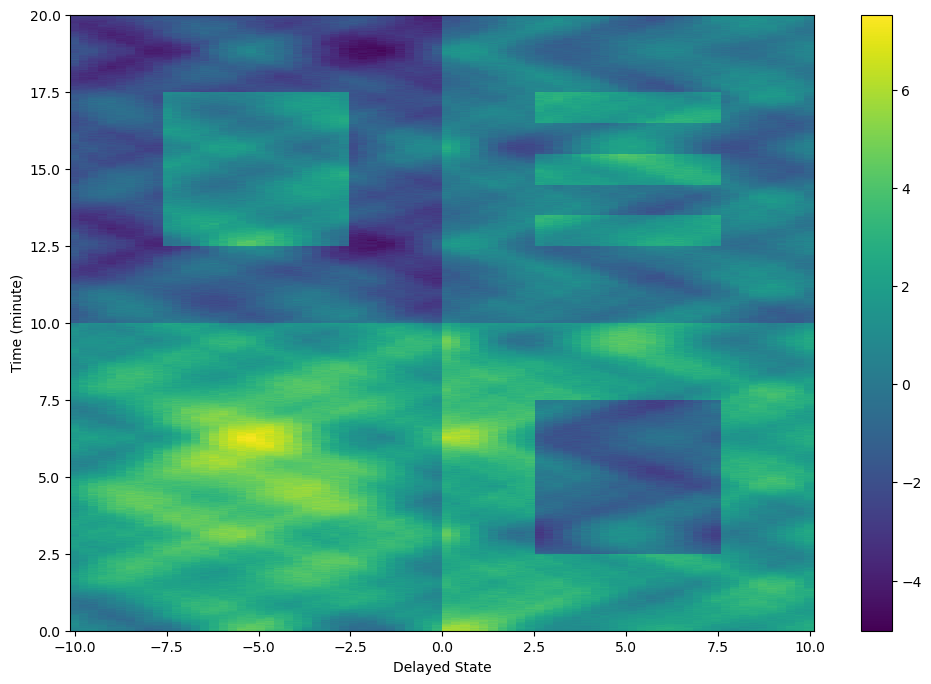

[[ 0.58832441+0.j          0.90046333+0.j          0.8132438 +0.j
  ...  2.30828436+0.j          2.67643414+0.j
   2.50255447+0.j        ]
 [ 0.74561367-0.00734152j  0.96877544+0.04176669j  0.74596445+0.05542915j
  ...  2.2726772 +0.02111281j  2.48525805+0.01967107j
   2.72909421+0.01707468j]
 [ 0.78887589-0.01423663j  0.80988268+0.08314356j  0.9437994 +0.11026858j
  ...  2.46655167+0.04192131j  2.54529453+0.03922329j
   2.6921759 +0.03430401j]
 ...
 [-2.75498229-1.12321589j -2.59395639-1.54139105j -2.82051051-1.77240007j
  ...  0.96891002+0.0270401j   0.95620585+0.03847203j
   0.71511253-0.14879505j]
 [-2.91771364-1.15180011j -2.54574584-1.56158636j -2.63426298-1.79471015j
  ...  1.07693588+0.0516073j   0.85098391+0.06720355j
   0.6712804 -0.12221225j]
 [-2.64903982-1.17707811j -2.39398647-1.5794722j  -2.4037852 -1.81599203j
  ...  1.17523862+0.07452282j  0.87254915+0.09459939j
   0.50864732-0.09248494j]]


In [5]:
make_plot(D.T, x=x, y=t)
print(D.T)

Creazione della funzione Singular Value Hard-Threshold 

In [6]:
def svht(X, sv=None):
    # svht for sigma unknown                                              ## si applica la svht per trovare la matrice sigma
    m,n = sorted(X.shape) # ensures m <= n                                ## sorted(X.shape) ordina la dimensione della matrice
                                                                          ## campionata. Si assicura che la dimensione della
                                                                          ## matrice ortogonale di destra sia maggiore della
                                                                          ## dimensione della matrice ortogonale di sinistra.
                
    beta = m / n # ratio between 0 and 1                                  ## beta è il median singular value della matrice X
    
    if sv is None:                                                        ## sv -> singular value
        sv = svdvals(X)
    sv = np.squeeze(sv)                                                   ## np.squeeze() remove axes of length one from a.
    
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43   ## approssimazione di omega
    
    return np.median(sv) * omega_approx                                   ## np.median(sv) * omega_approx equivale al Tau
                                                                          ## che sarebbe la soglia dell'SVHT

# determine rank-reduction
sv = svdvals(X)
tau = svht(X, sv=sv)
r = sum(sv > tau)

Creazione del metodo DMD.

In [7]:
def dmd(X, Y, truncate=None):
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix                 ## U2,Sig2,Vh2 SVD senza troncamento della matrice X
            
        r = len(Sig2) if truncate is None else truncate # rank truncation ## len(Sig2) equivale al numero di elementi di Sig2
        
        U = U2[:,:r]                                                      ## U matrice troncata, da (80,15) a (80,7)
        Sig = diag(Sig2)[:r,:r]                                           ## Sig matrice troncata, da (15,) a (7,7)
        V = Vh2.conj().T[:,:r]                                            ## V matrice troncata, da (15,15) a (15,7)
                                                                          ## conj() è la congiunta
        
        Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde  ## A tilde è la proiezione di A su U,
                                                                          ## dot() è il prodotto scalare tra due array
            
        mu,W = eig(Atil)                                                  ## eig() calcola gli autovalori (mu) e gli autovettori
                                                                          ## destri di una matrice quadrata
            
        Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes          ## phi equivale ai modi dinamuci del DMD
                                                                          
    return mu, Phi                                                        ## dmd restituisce mu(autovalori) e phi(modi dinamici)

# "mu" rappresenta gli autovalori del sistema dinamico rappresentato dalla matrice di dati.
# Gli autovalori sono valori numerici che descrivono la stabilità e la dinamica del sistema.

# "phi" rappresenta i modi dinamici o le funzioni proprie del sistema.
# Questi modi dinamici sono funzioni che descrivono il comportamento del sistema in base alla sua dinamica intrinseca.

Creazione del metodo mrDMD.

In [8]:
def mrdmd(D, level=0, bin_num=0, offset=0, max_levels=7, max_cycles=2, do_svht=True):
    """Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding."""

    # 4 times nyquist limit to capture cycles                 ## per il teorema di nyquist, un segnale sinusoidale puo'
                                                              ## essere ricostruito senza perdere informazioni, fintanto che 
                                                              ## viene campionato ad una frequenza due volte o piu' maggiori
                                                              ## della frequenza massima. (valore tipico: 4 volte maggiori)
                
    nyq = 8 * max_cycles                                      ## nyq = 8 * 2

    # time bin size
    bin_size = D.shape[1]                                     ## bin_size equivale al numero di colonne (1600)
    if bin_size < nyq:                                        ## bin_size(1600)<nyq(16)
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles   ## floor è una funzione che approssima per difetto
                                                                     ## esempio floor(2.9) equivale a 2.
                                                                     ## in questo caso bin_size / nyq == 100 , quindi step=100
            
    _D = D[:,::step]                                           ## D[:,:] è uno slice assignment, in particolare D[:,::step]
                                                               ## considera i valori presi ogni step di tutte le righe e crea
                                                               ## una nuova matrice con solo i valori considerati.
        
    X = _D[:,:-1]                                              ## in X considera tutti i valori (di _D) escludendo l'ultima 
                                                               ## colonna.
    
    Y = _D[:,1:]                                               ## in Y considera tutti i valori (di _D) escludendo la prima 
                                                               ## colonna.

    # determine rank-reduction
    if do_svht:
        _sv = svdvals(_D)                                      ## svdvals(_D) trova i valori singolari della matrice campionata
                                                               ## _sv è un array con i valori singolari. 
        
        tau = svht(_D, sv=_sv)                                 ## tau -> soglia SVHT
        r = sum(_sv > tau)                                     ## r equivale al n. di valori singolari maggiori della soglia tau
    else:
        r = min(X.shape)                                       ## r -> X.shape = (80, 15) quindi r=min(X.shape) è 15.
        
    # compute dmd
    mu,Phi = dmd(X, Y, r)                                      ## applica il dmd alle matrici campionate
    
    # frequency cutoff (oscillations per timestep)
    rho = max_cycles / bin_size                                ## frequenza di taglio rho definita come n° max di modi dinamici
                                                               ## classificati come "slow" diviso il numero di colonne della
                                                               ## matrice D.  2/1600=0.00125

    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho       ## ritorna il valore assoluto [abs()] del logaritmo di mu diviso
                                                               ## 2*pi greco*step, che deve essere minore o uguale a rho.
                                                               ## in questo caso [false false false false true true false]
        
    n = sum(slow) # number of slow modes                       ## il numero dei modi "slow" è dato dalla somma di slow.
                                                               ## in questo caso 2.

    # extract slow modes (perhaps empty)                       ## si estrae i modi "slow"
    mu = mu[slow]                                              ## in mu salva solo gli autovalori "slow"
                                                               ## da 7 autovalori a 2 autovalori.

   
    Phi = Phi[:,slow]                                          ## in phi salva solo i modi dinamici "slow"
                                                               ## phi.shape era (80,7) adesso è (80,2).

    if n > 0:                                                  ## se il n° di modi "slow" è maggiore di zero

        # vars for the objective function for D (before subsampling)
        Vand = np.vander(power(mu, 1/step), bin_size, True)   ## vander() restituisce una matrice di Vandermonde, come paramentri
                                                              ## vanno passati: un array 1-D (in questo caso mu elevato a potenza
                                                              ## 1/1600), il numero di colonne dell'uscita e un valore booleano
                                                              ## che indica l'incremento (se True allora le colonne saranno
                                                              ## x^0, x^1, x^2... se False saranno x^(N-1), x^(N-2),...)
                        
        P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))  ## multiply() serve per moltiplicare due array.
                                                                                 ## in questo caso tra il [prodotto scalare della
                                                                                 ## la congiunta di phi trasposta e phi] e 
                                                                                 ## [la congiunta del prodotto scalare di Vand
                                                                                 ## e la congiunta di Vand trasposta]
        q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))    ##

        # find optimal b solution
        b_opt = solve(P, q).squeeze()                         ## b = P^-1 * q
                                                              ## solve() trova le radici di P risolvendo per q

        # time evolution
        Psi = (Vand.T * b_opt).T                              ## Psi matrice (2,1600)

    else:

        # zero time evolution
        b_opt = np.array([], dtype='complex')
        Psi = np.zeros([0, bin_size], dtype='complex')

    # dmd reconstruction
    D_dmd = dot(Phi, Psi)                                     ## D_dmd equivale al prodotto scalare tra i modi dinamici slow
                                                              ## e la matrice che rappresenta l'evoluzione nel tempo

    # remove influence of slow modes
    D = D - D_dmd                                             ## Rimuove dai dati rimanenti le componenti slow

    # record keeping
    node = type('Node', (object,), {})()
    node.level = level            # level of recursion
    node.bin_num = bin_num        # time bin number
    node.bin_size = bin_size      # time bin size
    node.start = offset           # starting index
    node.stop = offset + bin_size # stopping index
    node.step = step              # step size
    node.rho = rho                # frequency cutoff
    node.r = r                    # rank-reduction
    node.n = n                    # number of extracted modes
    node.mu = mu                  # extracted eigenvalues
    node.Phi = Phi                # extracted DMD modes
    node.Psi = Psi                # extracted time evolution
    node.b_opt = b_opt            # extracted optimal b vector
    nodes = [node]

    # split data into two and do recursion                    ## Qui i dati rimanenti vengono divisi in due e viene applicato
                                                              ## nuovamente il mrdmd su entrambe le metà e così via in modo
                                                              ## ricorsivo...
   
    if level < max_levels:
        split = ceil(bin_size / 2) # where to split           ## ceil(x) approssima per eccesso x
        nodes += mrdmd(
            D[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
        nodes += mrdmd(
            D[:,split:],
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
    return nodes                                              ## la funzione ritorna una lista di nodi che rappresenta
                                                              ## l'evoluzione dei dati spazio-temporali nel tempo

Esecuzione del metodo mrDMD.

In [9]:
nodes = mrdmd(D)

Creazione della funzione stitch che permette l'unione dei vari livelli di ricorsione.

In [10]:
def stitch(nodes, level):

    # get length of time dimension
    start = min([nd.start for nd in nodes])
    stop = max([nd.stop for nd in nodes])
    t = stop - start

    # extract relevant nodes
    nodes = [n for n in nodes if n.level == level]
    nodes = sorted(nodes, key=lambda n: n.bin_num)

    # stack DMD modes
    Phi = np.hstack([n.Phi for n in nodes])

    # allocate zero matrix for time evolution
    nmodes = sum([n.n for n in nodes])
    Psi = np.zeros([nmodes, t], dtype='complex')

    # copy over time evolution for each time bin
    i = 0
    for n in nodes:
        _nmodes = n.Psi.shape[0]
        Psi[i:i+_nmodes,n.start:n.stop] = n.Psi
        i += _nmodes

    return Phi,Psi

Rappresentazione dei modi dinamici e dell'evoluzione nel tempo dei dati.

In [11]:
Phi0,Psi0 = stitch(nodes, 0)
Phi1,Psi1 = stitch(nodes, 1)
Phi2,Psi2 = stitch(nodes, 2)

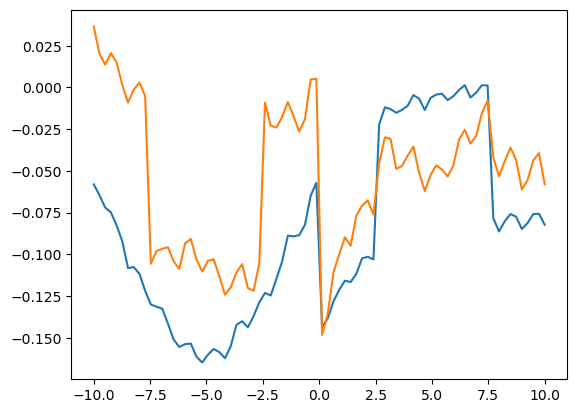

In [12]:
fig = plt.plot(x, Phi0.real)

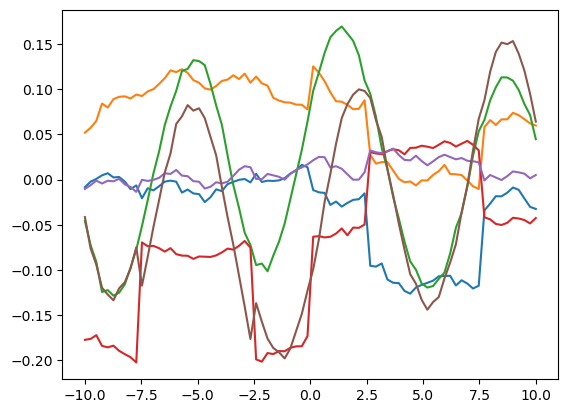

In [13]:
fig = plt.plot(x, Phi1.real)

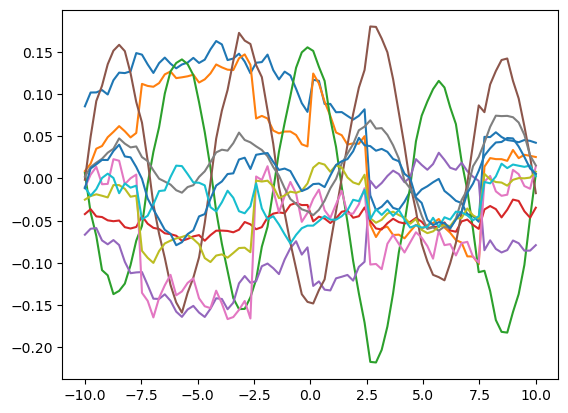

In [14]:
fig = plt.plot(x, Phi2.real)

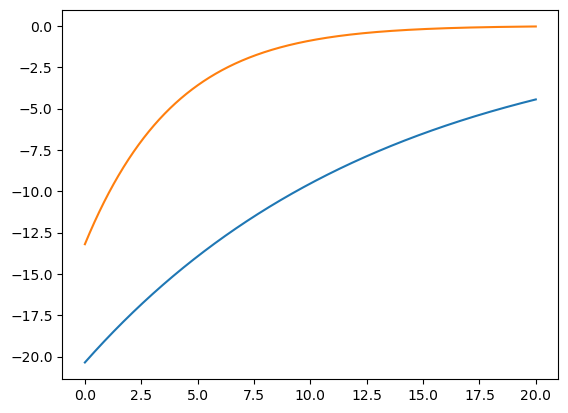

In [15]:
fig = plt.plot(t, Psi0.real.T)

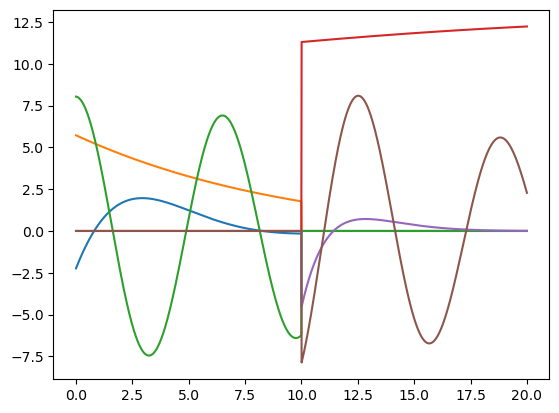

In [16]:
fig = plt.plot(t, Psi1.real.T)

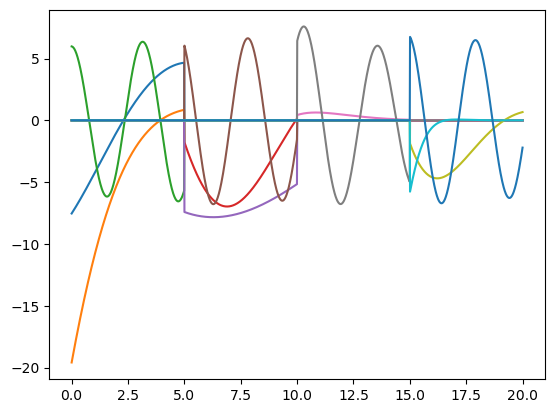

In [17]:
fig = plt.plot(t, Psi2.real.T)

Inizializzazione del primo livello di ricorsione.

In [18]:
D_mrdmd = dot(*stitch(nodes, 0))

Creazione della funzione per il calcolo dell'errore quadratico medio (MSE).

In [19]:
def mean_squared_error(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

Unione dei vari livelli di ricorsione con relativo errore MSE ad ogni iterazione.

Rappresentazione grafica dataset iniziale:


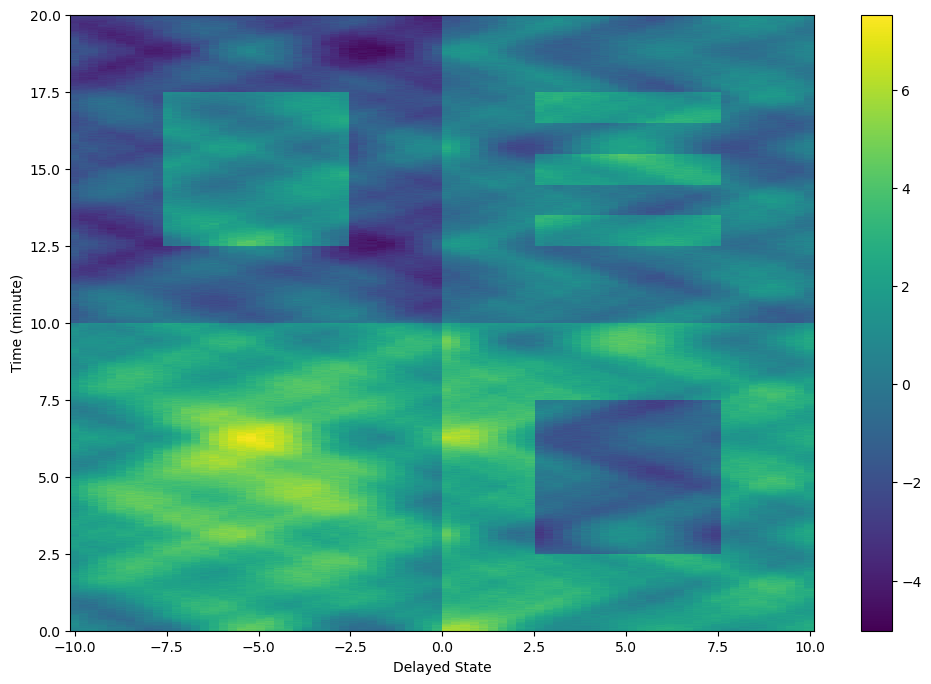

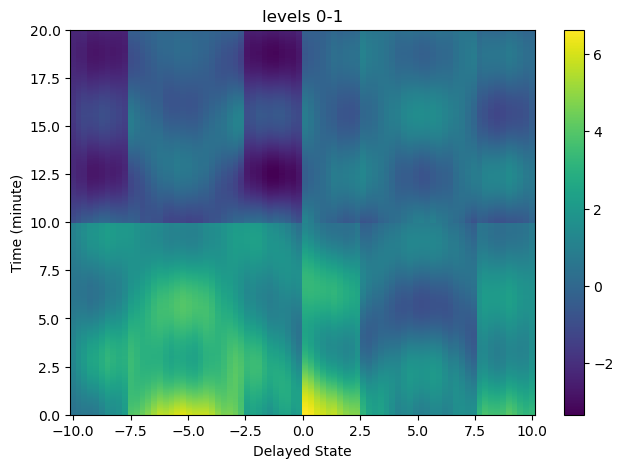

Percentuale di errore:
1.9069088006 %


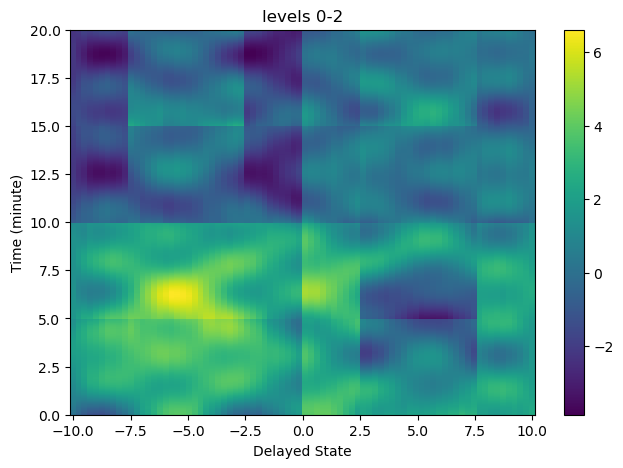

Percentuale di errore:
0.7644029557 %


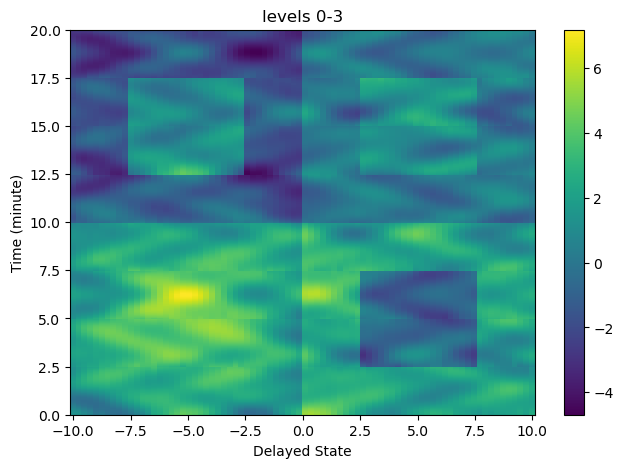

Percentuale di errore:
0.0881994046 %


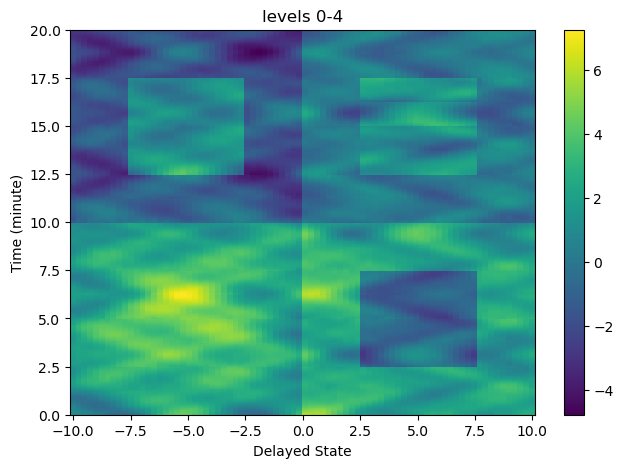

Percentuale di errore:
0.0444063681 %


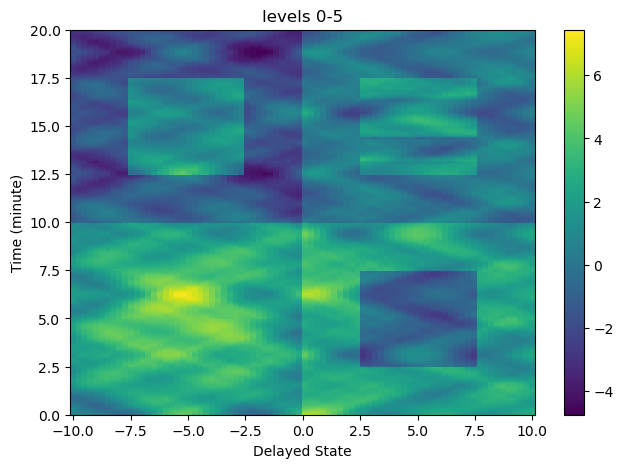

Percentuale di errore:
0.0217055992 %


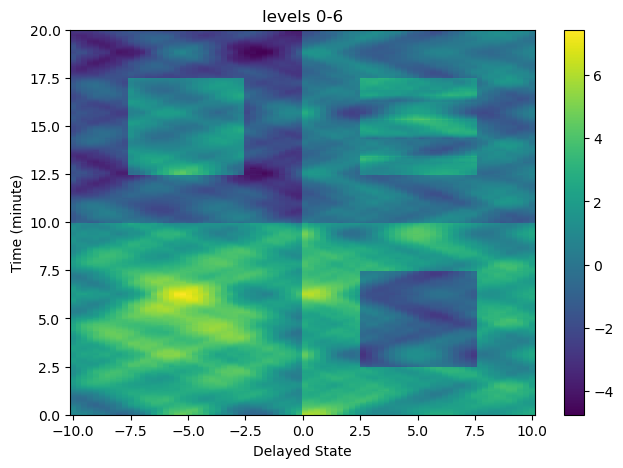

Percentuale di errore:
0.0180463202 %


In [20]:
print("Rappresentazione grafica dataset iniziale:")
make_plot(D.T, x=x, y=t)

for i in range(1, 7):
    D_mrdmd += dot(*stitch(nodes, i))
    make_plot(D_mrdmd.T, x=x, y=t, title='levels 0-' + str(i), figsize=(7.5, 5))
    print("Percentuale di errore:")
    print(round(mean_squared_error(D_mrdmd.T,D.T),10),"%")
    
    
   

Trasformo la matrice del dataset e la matrice della ricostruzione in array ad una dimensione.

In [21]:
D0 = D[0,:]
D_0 = D_mrdmd[0,:]

Plotto l'andamento temporale sia del dataset che della ricostruzione e ne calcolo la differenza tra i due.

C:\Users\User\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


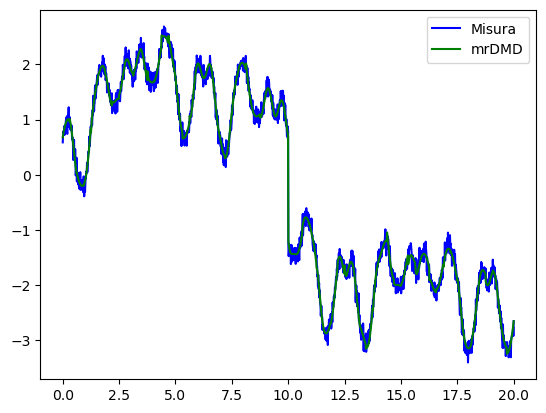

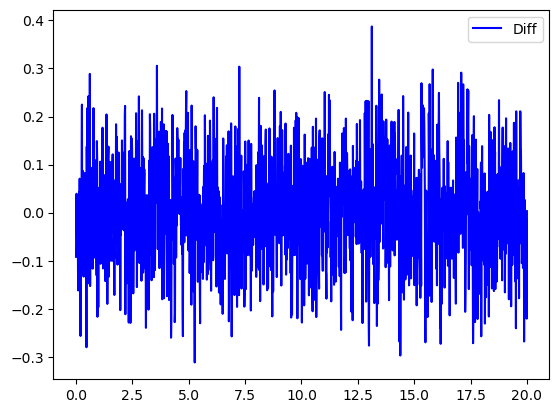

In [22]:
plt.figure()
plt.plot(t, D0, 'b', label='Misura')
plt.plot(t, D_0.real, 'g', label='mrDMD')
plt.legend()
plt.show()

plt.figure()
error=np.array(D0) - np.array(D_0)
plt.plot(t, error.real, 'b', label='Diff')
plt.legend()
plt.show()